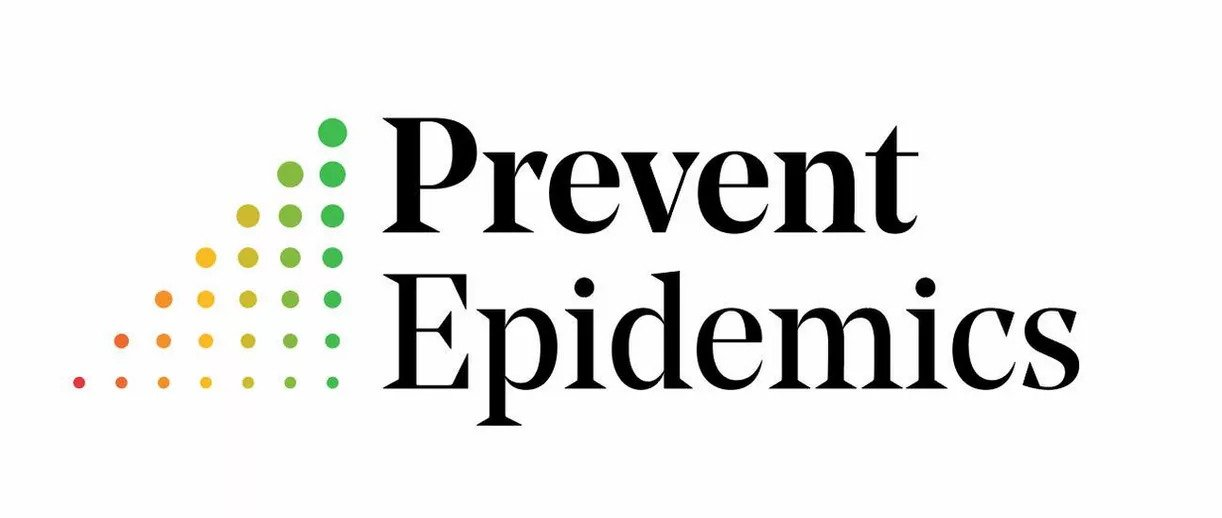

In [22]:
DisplayImage(images_dir / 'prevent_epidemics.jpg', width=1200)

# The Problem

<font color='#005b96'>
We're in the middle of world wide disaster because of COVID19,<br>
One of the best proven ways to prevent the virus from being publicly spread is to <b>wear masks</b>.<br>
However, not everyone being logically always, <br>
Some people decide not to wear a mask, and those, <br>
put all of us in <b>danger</b>.<br>

    
Therefore, it is very urgent to improve the recognition performance of the existing face recognition technology on the masked faces.<br>
    Most current advanced face recognition approaches are designed based on <b>deep learning</b>,<br>
which depend on a large number of face samples.<br>
The purpose of this pseudo system is to detect people with and w/o mask.<br>
And by that help all of us return to normal life ASAP :)

# Consts

In [1]:
from consts import *

In [2]:
np.random.seed(seed)

In [3]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# The Data

<font color='#005b96'>
Inorder to build a good classifier we have to have large amount of labeled data(images).<br>
We need the data to be representative and large enough so our models could learn the boundaries between the two classes properly.<br>
The dataset i used called RMFRD and it came from this paper:
    <h3>https://arxiv.org/pdf/2003.09093.pdf</h3>
According to the dataset's description,<br>
A python crawler tool is used to crawl the front-face images of public figures and their corresponding masked face images from massive Internet resources.<br>
Then, they manually remove the unreasonable face images resulting from wrong correspondence.<br>
The process of filtering images takes a lot of manpower.<br>
Similarly, they crop the accurate face areas with the help of semi-automatic annotation tools, like LabelImg and LabelMe.<br>
The dataset includes 5,000 pictures of 525 people wearing masks, and 90,000 images of the same 525 subjects without masks.<br>
They also claim that this is currently the world’s largest real-world masked face dataset.

# Prepare the data

In [4]:
if ALREADY_TRAINED:
    from torchvision.models import resnet18
    
    BEST_MODEL_PATH = Path(resnet_model_dir / 'model_new_2')
    df = pd.read_csv(rmfd_dataset_dir / Path('ds.csv'))
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(str(base_dir / BEST_MODEL_PATH), map_location=torch.device(device)))

In [6]:
import os
from collections import Counter

if not ALREADY_TRAINED:
    w_mask_imgs_path_list, wo_mask_imgs_path_list = [], []
    w_mask_cnt = Counter()
    wo_mask_cnt = Counter()

    for img_path in imgs_w_mask.rglob('*'):
        if '.' in img_path.name and os.path.isfile(img_path):
            w_mask_imgs_path_list.append(img_path)
            w_mask_cnt.update([img_path.name.split('.')[-1]])
        
    for img_path in imgs_wo_mask.rglob('*'):
        if '.' in img_path.name and os.path.isfile(img_path):
            wo_mask_imgs_path_list.append(img_path)
            wo_mask_cnt.update([img_path.name.split('.')[-1]])

In [ ]:
# Top files extentions
if not ALREADY_TRAINED:
    print(f'Masked images extentions\'s counter: {w_mask_cnt.most_common()}')
    print(f'W/O mask images extentions\'s counter: {wo_mask_cnt.most_common()}')

Masked images extentions's counter: [('jpg', 2118), ('png', 65), ('jpeg', 17), ('JPEG', 3)]
W/O mask images extentions's counter: [('jpg', 90468)]


In [20]:
# Great so let's store the path to the images at DataFrame
if not ALREADY_TRAINED:
    # Adding masked images
    df = pd.DataFrame(zip(w_mask_imgs_path_list, len(w_mask_imgs_path_list)*[1]), columns=['img_path', 'label'])
    # Adding images withous mask
    df = df.append(pd.DataFrame(zip(wo_mask_imgs_path_list, len(wo_mask_imgs_path_list)*[0]), columns=['img_path', 'label']))
    df.reset_index(inplace=True, drop=True)
    df.head(2), df.tail(2)

(                                            img_path  label
 0  /content/drive/My Drive/Colab Notebooks/Mask D...      1
 1  /content/drive/My Drive/Colab Notebooks/Mask D...      1,
                                                 img_path  label
 92669  /content/drive/My Drive/Colab Notebooks/Mask D...      0
 92670  /content/drive/My Drive/Colab Notebooks/Mask D...      0)

In [7]:
df.shape

(92671, 2)

# EDA

<font color='#005b96'>
Let's explore our data, we know we should have 2 classes, one for people with mask and one for people without.<br>
In addition, we have to check the datasets' owners claims regarding the amount of images the datasets consists of.<br>
Furthermore, we have to ensure the quality of the images.<br>
If the quality won't be good enough we can get another dataset or consider crawling websites.<br>
We need to check what is the percentage of each class? is it enough for the model to draw boundaries between the classes? (This answer will be answered only after the model evalutaion)

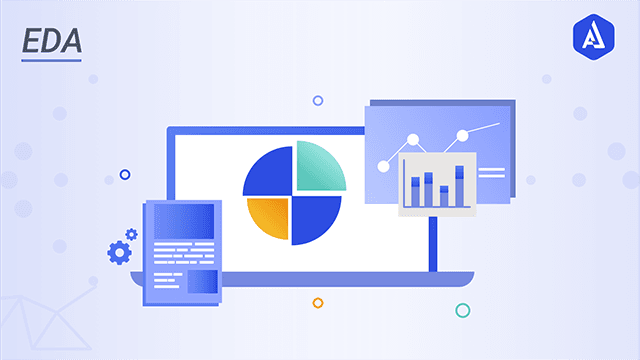

In [13]:
DisplayImage(images_dir / 'eda.png', width=1200)

In [9]:
df

img_path  label
0      datasets/self-built-masked-face-recognition-da...      1
1      datasets/self-built-masked-face-recognition-da...      1
2      datasets/self-built-masked-face-recognition-da...      1
3      datasets/self-built-masked-face-recognition-da...      1
4      datasets/self-built-masked-face-recognition-da...      1
...                                                  ...    ...
92666  datasets/self-built-masked-face-recognition-da...      0
92667  datasets/self-built-masked-face-recognition-da...      0
92668  datasets/self-built-masked-face-recognition-da...      0
92669  datasets/self-built-masked-face-recognition-da...      0
92670  datasets/self-built-masked-face-recognition-da...      0

[92671 rows x 2 columns]

In [6]:
df[['label']].nunique().item()

2

<font color='#005b96'>
It seems like the dataset has 2 classes as it should.

<font color='#005b96'>
Let's have a look on the classes distribution

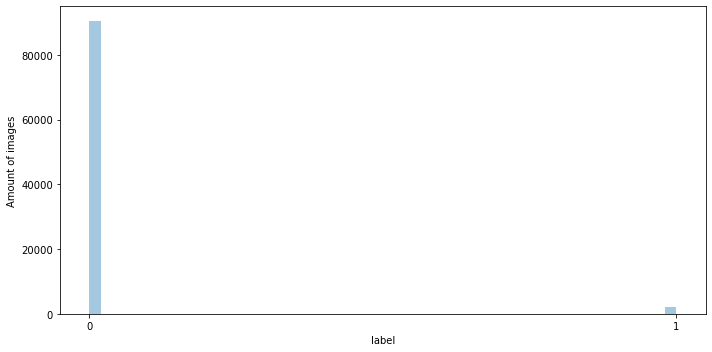

In [10]:
plt.figure(figsize=(10,5))

sns.distplot(df['label'], kde=False)
plt.xticks([0,1])
plt.ylabel('Amount of images')
plt.tight_layout()

In [11]:
print(f"The total amount of images of people without mask is: {df.groupby(['label']).count().iloc[0].item()}")
print(f"The total amount of images of people with mask is: {df.groupby(['label']).count().iloc[1].item()}")
print(f'The total amount of images is: {df.count()[-1]}')

The total amount of images of people without mask is: 90468
The total amount of images of people with mask is: 2203
The total amount of images is: 92671


<font color='#005b96'>
The number of images w/o mask match more or less to the authors' description, but the amount of images with mask is around half.<br>    
As we can see there is a huge imbalance between the classes,<br>
It means that there is a lot more images of people without a mask and the models may be balanced towrds this class.

<font color='#005b96'>
Let's have a look at the images

In [12]:
def plot_image_from_dataset(dataset, index_list, predict=True, model=None):
    import warnings
    warnings.filterwarnings(action='ignore')
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}

    plt.rc('font', **font)
    plt.figure(figsize=(10,10))
    for i, ds_index in enumerate(index_list):
        plt.subplot(22*10+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.array(dataset[ds_index][0].permute(1,2,0)))
        
        if predict:
            model.eval()
            str_ =  r'Does image %d contains a mask? %s'
            predction = model(torch.unsqueeze(dataset[ds_index][0], dim=0))
            prediction_as_bool = predction.item()>0
            plt.annotate(str(prediction_as_bool), (0,0), bbox=dict(boxstyle ="round", fc ="0.8"))
            print(str_ %(i, str(predction.item()>0)))
            print(f'Model certainty {(F.sigmoid(predction).item())}')

    plt.tight_layout();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


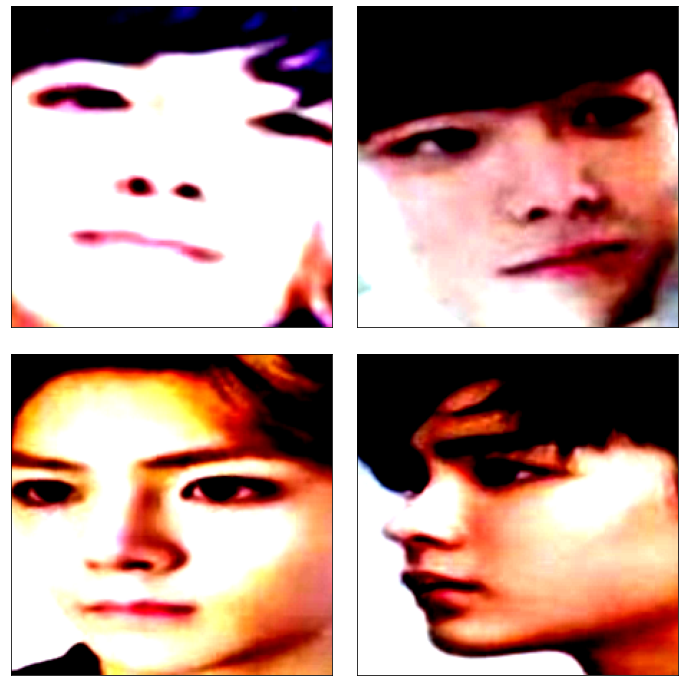

In [ ]:
plot_image_from_dataset(val_dataset, [1227, 1228, 1229, 1230], False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


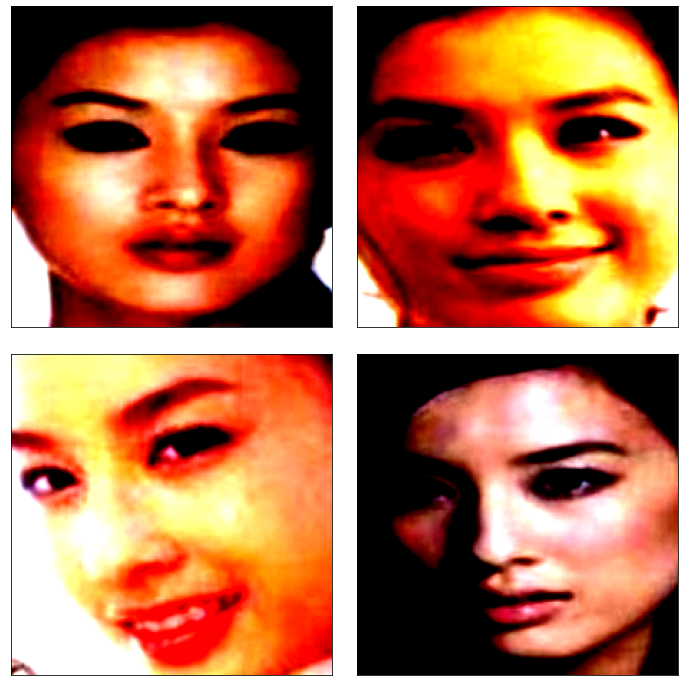

In [ ]:
plot_image_from_dataset(val_dataset, [10,11,12,13], False)

<font color='#005b96'>
After reviewing the images it seems like they already quiet diverse and also has fine quality,<br>
So i'll go easy with the transformations and only flip the images horizontally and crop.

# Modeling

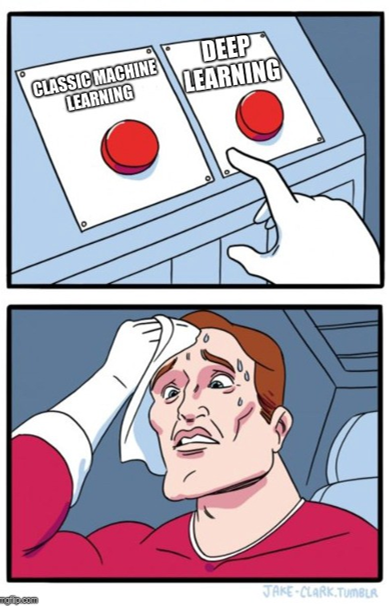

In [28]:
DisplayImage(images_dir / 'how_do_i_choose.png')

<font color='#005b96'>
We are going to examine two different models from two approches, <b>Machine Learning</b> and <b>Deep Learning</b>.<br>
The next picture emphasise the key differences between the two.<br>
While applying ML based algorithm we firstly need to extract meaningful features that could represent the data as good as possible.<br>
Those features is the key to set the boundaries between the two classes, if those won't be good enough we won't seperate precisely between the classes.<br>
On the other hand, while using deep learing, we don't extract the features manually.<br>
We let the NN extract those features for us (But… we’re paying in the need of searching for a good NN architecture and hours of training).<br>
There is Pros and Cons for the two options.<br>
But, when we are talking about Computer Vision tasks, in the last decad DL NN presented SOTA results.<br>
So we'll give a chance for ML based algorithm but the expectation is that the DL NN would beat the ML based algorithm.<br>
For the Machine Learning algorithm i chose RandomForest algorithm.<br>
<b>RandomForest</b> is an algorithm which based on bagging + random subspaces for decision trees.<br>
Bagging  - Every tree would be built with random samples from the DS<br>
Random Subspaces - Every tree would be built with random features from the DS<br>
While using RF for classification we would get a prediction from each one of the DecisionTrees and then take the majority vote to be our prediction.<br>
<br>
For the Deep Learning NN we are going to use <b>resnet18</b>, It will get explained further at the NN part.

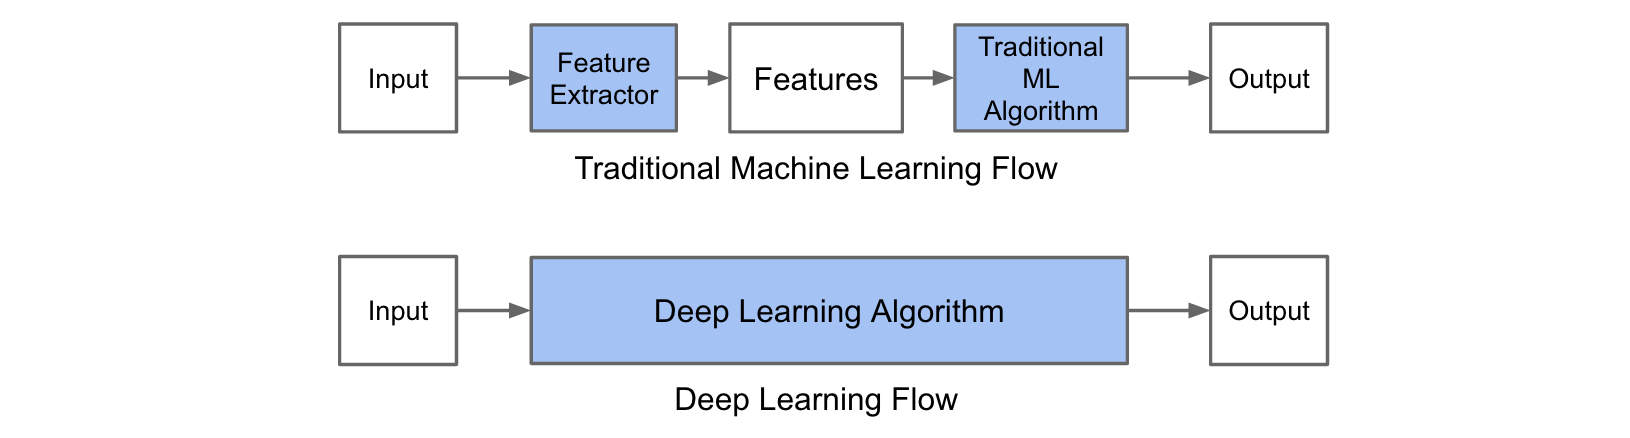

In [29]:
DisplayImage(images_dir / 'ml_vs_dl.png')

http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/

RandomForest



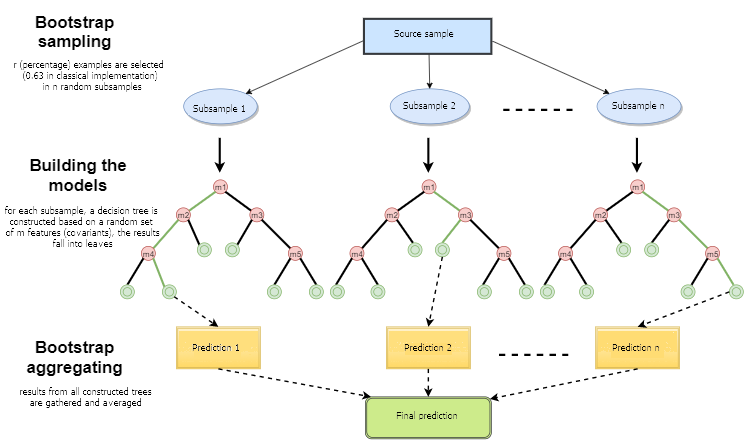

In [36]:
print('RandomForest')
print()
DisplayImage(images_dir / 'rf.png')

https://www.mql5.com/en/articles/3856


## Machine Learning model - RandomForest

<font color='#005b96'>
Let's preprocess the data in a way that the RandomForest classifier provided by sklearn could fits on.<br>
Remember that RF should get the features for every sample and the actual label in order to train on.<br>
But we got images, what could be the features?
One possible answer is to use the lowest building blocks image has, the <b>pixels</b>.<br>
But we have a problem... each image has different hieght and width and the amount of features should be const.<br>
We could solve this by using pytorch transformation called resize.<br>
For each image we're going to change it height and width to 224x224.<br>
If the image height and or width is larger than 224 we would just take a random crop.<br>
If the image height and or width is smaller than 224 we would just apply bilinear interpolation.<br>
One more important thing is that sklearn model should get a mutable object of 1D objects.<br>
Therefore we must flat the images to 1D.

In [5]:
from tqdm.notebook import tqdm
import cv2

X = []
y = []
INPUT_SIZE=224
err_cnt = 0
for r in tqdm(df.itertuples()):
    try:
        img = T.Compose([T.RandomResizedCrop(INPUT_SIZE)])(Image.fromarray(plt.imread(str(r.img_path))))
        X.append(np.array(img).flatten())
        y.append(r.label)
    except Exception as e:
        err_cnt += 1
    
f"Amount of images that the system failed to load because of invalid path's charachters for windows is {err_cnt}", f'Amount of valid images is: {len(X)}'

("Amount of images that the system failed to load because of invalid path's charachters for windows is 65",
 'Amount of valid images is: 92606')

In [6]:
def print_metrics(tn, fp, fn, tp):
    acc = (tp+tn) / (tn + fp + fn + tp)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    nfr = tn / (tn + fp)
    auc = roc_auc_score(y_test, y_pred)
    precision = tp / (tp + fp)
    f1 = 2*precision*tpr / (precision+tpr)
    print(f'Accuracy: {acc:.4f}')
    print(f'True Positive Rate: {tpr:.4f}')
    print(f'False Positive Rate: {fpr:.4f}')
    print(f'False Negative Rate: {fpr:.4f}')
    print(f'AUC: {auc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 score: {f1:.4f}')

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

model = RandomForestClassifier()
model.fit(X_train, y_train);

The classifier ended his training, let's see how would it generalize to unseed data.

In [63]:
from sklearn.metrics import confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print_metrics(tn, fp, fn, tp)

Accuracy: 0.9845
True Positive Rate: 0.3808
False Positive Rate: 0.0012
AUC: 0.6898
Precision: 0.8811
F1 score: 0.5318


<font color='#005b96'>
If we were looking only the Accuracy, we could think that the classifier is damn good.<br>
But together with the other metrics we could conclude that the RF classifier didn't set very good boubdaries between the classes.<br>
While the FPR is reasonble the TPR is poor and we cannot use such a system with detection rate of ~40%<br>
The AUC and the F1 score which take into account the prior of both classes have also poor results.<br>
From the FPR we can infer, if our dataset is really i.i.d and representative for the wild,<br>
that out of 10,000 only for 12 people the model would predict "has mask" while actually he is spreading the disease.<br>
And from the precision we could conclude that for 10 people that were predicted as "wearing mask",<br>
9 of them really has mask.<br>
Latter on i will give further mathematical explanation about those metrics.

<font color='#005b96'>
Let's have a look at the actual True Negative, False Positive, False Negative and True Positive constants.

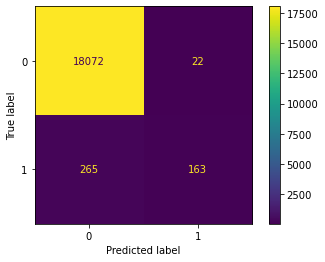

In [71]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)
plt.show()

<font color='#005b96'>
As we suspected the high accuraccy is due to the fact that the model predicted almost always "no mask",<br>
And because of the mass of this class we got a really large value of the TN, this idea will be explained further in extensive.

In [ ]:
# Let's free some memory
import gc
del X_train, X_test, y_train, y_test
gc.collect()

## Deep Learning model - ResNet18

<font color='#005b96'>
I'll use transfer learning instead of training a network from scratch.<br>
This way i don't have to have a huge dataset and learn the low level features.<br>
My dataset is medium sized, it consists of 90K images.<br>
I chose to fine-tune resnet18 for this task from three main reasons.<br>
The first one is that i read the paper of resnet and feeling kind of comfortable to modify the backbone of the network if i'll need to.<br>
Secondly, this network is kind of small compared to other networks that were created for classification tasks.<br>
Thirdly, it presented SOTA results on ImageNet and pytorch easily gives me the wieghts of the network after it was trained on ImageNet for classify between 512(specifically resnet18) classes.

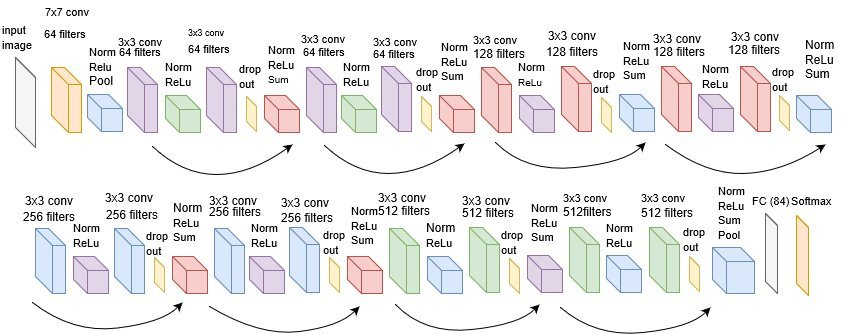

In [13]:
DisplayImage(images_dir / 'resnet18.png')

<font color='#005b96'>
In order to create the NN pytorch has to get the data in a certain way.<br>
We must implement a dataset with 3 functions, __init__, __len__ and __get_item__.<br>
That way pytorch could read the data correctly.

In [14]:
class MaskDataset(Dataset):
    def __init__(self, df, transformers=None):
        super().__init__()
        self.df = df
        self.transformers = transformers
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img = Image.open(str(self.df.loc[idx,'img_path']))
        label = self.df.loc[idx,'label']
        if self.transformers:
            img = self.transformers(img)
        return img, torch.tensor(label, dtype=torch.float64)

<font color='#005b96'>
I am going to apply several transformations for the input images,<br>
and i can divide those for two classes:<br>
1. transformations that are applied because I want to create more data,<br>
    and make the network struggle so as a result it would generalize better.<br>
    Those transformation include: RandomResizedCrop, RandomHorizontalFlip.<br>
2. transformations that made from backward compatiablity like Normalize.<br>
    Because i used tranfer learning from resnet18 that was trained on images with certain mu and std,<br>
    My input images has to be normalized that way also.

<font color='#005b96'>
It's also important to create transformations for train and for validation.<br>
In the validation i don't want to fool my model, only resize and crop so the input to the model always have the same dimensionality.<br>

In [15]:
from collections import defaultdict


INPUT_SIZE = 224
def get_transform(dataset_type):
    data_transforms = {
        'train': T.Compose([
            T.RandomResizedCrop(INPUT_SIZE),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': T.Compose([
            T.Resize(INPUT_SIZE),
            T.CenterCrop(INPUT_SIZE),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    dd = defaultdict(lambda: data_transforms['train'])
    dd.update(data_transforms)
    return dd[dataset_type]

In [16]:
from functools import partial

train_transform = partial(get_transform, 'train')
val_transform = partial(get_transform, 'val')

<font color='#005b96'>
Because i barelly have images of people with mask,<br>
It's really important that the train and the validation has the same percentage of images with masks.<br>
Otherwise it's really likely that the validation will only contains images w/o mask.<br>
And the validation metrics won't be reliable.

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=seed)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)
train_set.shape, test_set.shape

((74136, 2), (18535, 2))

In [18]:
train_set['label'].sum()/train_set['label'].size, test_set['label'].sum()/test_set['label'].size

(0.023767130678752562, 0.023792824386296197)

<font color='#005b96'>
Excellent the train & validation actually have the same frequency of mask and w/o mask

In [19]:
from sklearn.model_selection import train_test_split

dataloaders = {}

train_size = int(len(df)*0.80) 
train_dataset = MaskDataset(train_set, train_transform())
val_dataset = MaskDataset(test_set, val_transform())

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)
dataloaders['train'], dataloaders['val'] = train_data_loader, val_data_loader

In [ ]:
if not ALREADY_TRAINED:
    from torchvision.models.resnet import resnet18

    model = resnet18(pretrained=True)
    model.fc

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<font color='#005b96'>
As we can see the last layer has 512 classes.<br>
While we have only two.<br>
I can create 2 neurons at the last layer and then to use CrossEntropyLoss.<br>
But, PyTorch has nice Loss function for binary classification,<br>                                                                 called, BCELoss, but i won't use it either.<br>
I have two classes and i want the model to predict for each input image the probability of being part of each class,<br>
I can achive it by several ways.<br>
The straight forward one is to apply some function,<br>
    which transorm the values of the last layer from the range [-inf, +inf] to the range [0,1]<br>
    That way i can get ,p, the probability for one class.<br>
    And the probability for the other is just 1-p.<br>
    But wait!<br>
    I know such a function that doing exactly this, the Sigmoid come to rescue!<br>
    So.....<br>
    Why not to apply Sigmoid to the output of the last layer and then just BCELoss?<br>
    From numerical reasons! #NumericalAnalysis1Rocks!<br>
    It's actually very common to apply Logarithim to the standard cross-entropy function.<br>
    The Log has the charachteristic of being a monotonic function which keeps the relationship between each class prediction the same.<br>
    And better than that, now we have the LogLoss function which consists of summation instead of multiplication.<br>
    The summation is numerically more stable, and because that 0 < p < 1 the |Log| is pretty large also, which is more robust.<br>

In [ ]:
# As i sayed it's binary classification i can use only one output neuron.
if not ALREADY_TRAINED:
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.fc

In [20]:
import time
import copy

from collections import defaultdict
from sklearn.metrics import roc_auc_score


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    val_stats = defaultdict(defaultdict)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        y, y_score = [], []

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #   In train mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(torch.flatten(outputs), labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        y += torch.flatten(labels.detach()).tolist()
                        y_score += torch.flatten(outputs.detach()).tolist()
                        val_stats[epoch]['y'] = y
                        val_stats[epoch]['y_score'] = y_score
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (torch.flatten(outputs>0) ==  labels).sum().item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            torch.save(model.state_dict(), f'{str(base_dir)}/model_new_{epoch}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_stats

<font color='#005b96'>
Regarding the training process.<br>
    I'd to train on GPU such a network.<br>
    I used Google Colab for this task.<br>
    First of all i tried to train the network with batch size of 128 because i thought that it'll be the best size with respect for the amount of samples i've.<br>
    But the training process took more then 12 hours for one epoch on K80 at Colab.<br>
    I noticed that i have some extra RAM available on Colab so i just increased the batch size to 256.<br>
    That way the training of the first epoch took me ~6 hours.<br>
    Google colab does'nt gaurentee that you'll have the GPU available all the time.<br>
    In fact, it gaurentees that you'll be kicked out if you're using Colab's notebook for more then 12h.<br>
    I was kicked out tens of times during the training and the validation process but eventually i nailed it.<br>
For furthere research i collected statistics during that process.


In [ ]:
if not ALREADY_TRAINED:
    # Setup the loss function
    criterion = nn.BCEWithLogitsLoss()

    # Let's add Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),
                                 eps=1e-08, weight_decay=0, amsgrad=False)

    num_epochs = 5
    model.to(device)
    # Train and evaluate
    model, val_acc_history, val_stats = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------



train Loss: 0.0410 Acc: 0.9860



val Loss: 0.0048 Acc: 0.9987

Epoch 1/4
----------



train Loss: 0.0169 Acc: 0.9950



val Loss: 0.0082 Acc: 0.9979

Epoch 2/4
----------



train Loss: 0.0155 Acc: 0.9954



val Loss: 0.0072 Acc: 0.9975

Epoch 3/4
----------



train Loss: 0.0123 Acc: 0.9960



val Loss: 0.0052 Acc: 0.9982

Epoch 4/4
----------



train Loss: 0.0112 Acc: 0.9966



val Loss: 0.0057 Acc: 0.9983

Training complete in 555m 55s
Best val Acc: 0.998651


<font color='#005b96'>
Intresting!<br>
The first model got the highest Accuracy score on the validation set.
Is it saying that this is the best model?<br><br>
Absolutly not!<br><br>
Because of the huge imabalance between the classes Accuracy may not be the best metric.<br>
Think about a dummy model which always predict "No Mask",<br>
That model has Accuracy of 0.976 !<br>
This is why i bothered to collect more stats, because i have better metircs to examine how well each model have done.


In [21]:
print(f"Accuracy of dummy model which always predicts No mask, with 3 significant digits and round is: {np.round(float(df.groupby(['label']).count().loc[0,:] / df.groupby(['label']).count().sum()), 3)}")

Accuracy of dummy model which always predicts No mask, with 3 significant digits and round is: 0.976


In [27]:
import pickle

if not ALREADY_TRAINED:
    with open(resnet_model_dir / 'val_stats', 'wb') as fp:
        pickle.dump(val_stats, fp)
else:
    with open(resnet_model_dir / 'val_stats', 'rb') as fp:
        val_stats = pickle.load(fp)

In [28]:
if not ALREADY_TRAINED:
    with open(resnet_model_dir / 'val_acc_history', 'wb') as fp:
        pickle.dump(val_acc_history, fp)
else:
    with open(resnet_model_dir / 'val_acc_history', 'rb') as fp:
        val_acc_history = pickle.load(fp)

<font color='#005b96'>
    <h2>Area under the Curve</h2>

<font color='#005b96'>
Area Under the ROC Curve could be a great metric because it takes into account the prior of each distribution.<br>
The ROC curve is build by calculating for a lot of thresholds between zero and one, the corresponding False Positive Rate as the X-axis and the True Positive Rate(Recall) as the Y-Axis.
And the AUC is just the integral of this curve between 0 and 1.<br>
That way we get a single number which represent how good the model perform.

In [27]:
from sklearn.metrics import roc_auc_score

auc_list = []
for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    auc = roc_auc_score(y, torch.sigmoid(torch.tensor(y_score)))
    auc_list.append(auc)
    print(f'Epoch {epoch} - Area under ROC curve: {auc}')
    print()

Epoch 0 - Area under ROC curve: 0.9997483537094142

Epoch 1 - Area under ROC curve: 0.9987596895727452

Epoch 2 - Area under ROC curve: 0.9998156515470857

Epoch 3 - Area under ROC curve: 0.9996197734832484

Epoch 4 - Area under ROC curve: 0.9995781666264384



<font color='#005b96'>
We can also see those results in a nice plot.

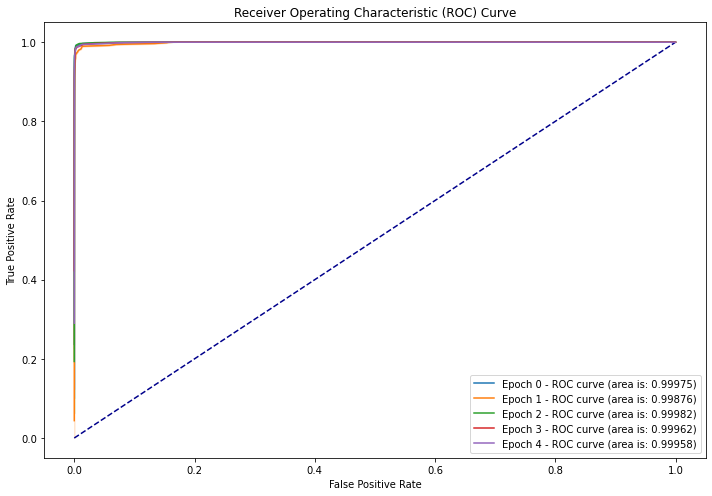

In [29]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

for i, (epoch, stats) in enumerate(val_stats.items()):
    fpr, tpr, thresh = roc_curve(stats['y'], stats['y_score'])          
    df = pd.DataFrame(list(zip(fpr, tpr)), columns=['False Positive Rate', 'True Positive Rate'])
    sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df,
                label=f'Epoch {i} - ROC curve (area is: {round(auc(fpr, tpr), 5)})', estimator='mean')
plt.tight_layout()        

<font color='#005b96'>
Because of the minor difference between the results, we could have a look at the log scale.

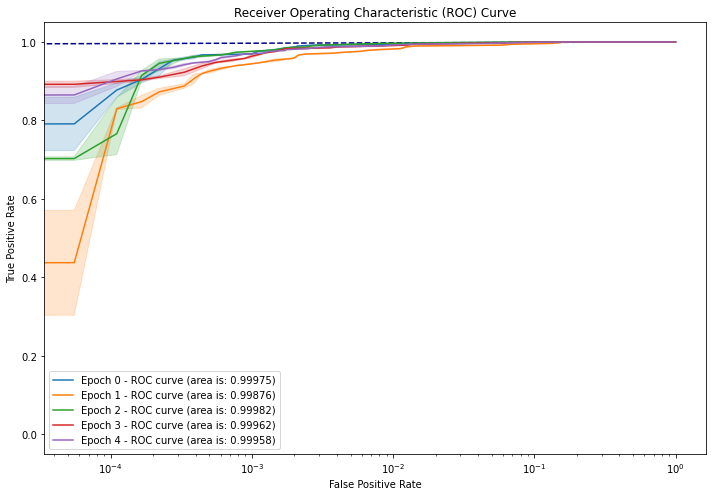

In [30]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

for i, (epoch, stats) in enumerate(val_stats.items()):
    fpr, tpr, thresh = roc_curve(stats['y'], stats['y_score'])          
    df = pd.DataFrame(list(zip(fpr, tpr)), columns=['False Positive Rate', 'True Positive Rate'])
    ax = sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df,
                      label=f'Epoch {i} - ROC curve (area is: {round(auc(fpr, tpr), 5)})', estimator='mean')
    ax.set(xscale="log")
plt.tight_layout()        

<h2>Other metrics</h2>

*   True Positive Rate or recall:<br>
The percentage of masked images that were detected to all masked images.<br>
$$
TPR = TP / (TP+FN)
$$
*   False Positive Rate:<br>
The percentage of images w/o mask that detected as images with mask to all the unmasked images.<br>
$$
FPR = FP / (FP+TN)
$$


*   Precision:<br>
The percentage of masked images that were detected to all the images that were reported as masked images.<br>
$$
Precision = TP / (TP+FP)
$$


*   F1-Score:<br>
If we'll set the classification threshold to 0.00001, the recall would be close to 1(100%),<br>
Because we'll report almost each and every image as masked.<br>
And if we'll set the classification threshold to 0.99999, the precision would be close to 1(100%),<br>
Because we'll report almost each and every image as unmasked.<br>
So we have a motivation to some how "balance" between the two.<br>
And F1-Score is exactlly this.<br>
$$
F1 = 2 * Recall * Precision/(Recall+Precision)
$$


In [30]:
from sklearn.metrics import confusion_matrix

for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    tn, fp, fn, tp = confusion_matrix(y, [round(i.item()) for i in torch.sigmoid(torch.tensor(y_score))]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    f1 = 2*precision*tpr / (precision+tpr)
    print(f'Epoch {epoch} - True Positive Rate: {tpr}')
    print(f'Epoch {epoch} - False Positive Rate: {fpr}')
    print(f'Epoch {epoch} - Precision: {precision}')
    print(f'Epoch {epoch} - F1 score: {f1}')
    print()

Epoch 0 - True Positive Rate: 0.9569160997732427
Epoch 0 - False Positive Rate: 0.0003316016359014038
Epoch 0 - Precision: 0.985981308411215
Epoch 0 - F1 score: 0.9712313003452245

Epoch 1 - True Positive Rate: 0.9365079365079365
Epoch 1 - False Positive Rate: 0.000607936332485907
Epoch 1 - Precision: 0.9740566037735849
Epoch 1 - F1 score: 0.9549132947976878

Epoch 2 - True Positive Rate: 0.9863945578231292
Epoch 2 - False Positive Rate: 0.0022659445119929257
Epoch 2 - Precision: 0.9138655462184874
Epoch 2 - F1 score: 0.9487459105779716

Epoch 3 - True Positive Rate: 0.9569160997732427
Epoch 3 - False Positive Rate: 0.0007737371504366088
Epoch 3 - Precision: 0.9678899082568807
Epoch 3 - F1 score: 0.9623717217787913

Epoch 4 - True Positive Rate: 0.9387755102040817
Epoch 4 - False Positive Rate: 0.0002763346965845032
Epoch 4 - Precision: 0.9880668257756563
Epoch 4 - F1 score: 0.9627906976744187



<font color='#005b96'>
If i need to pick up the best model out of those four.<br>
I'm picking model no 2.<br>
There is no one good answer and the best model could vary by choosing different metrics.<br>
But as I explaied before, the AUC is one of the best metrics for this detection task.<br>
Furtheremore,<br>
Model 2 got the highest TPR which is also called, detection rate,<br>
It means that from all the pictures of people with masks,<br>
Model no 2 detects the most of them correctlly in compare to the others.<br>

In [31]:
stats_df = pd.DataFrame()

for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    tn, fp, fn, tp = confusion_matrix(y, [round(i.item()) for i in torch.sigmoid(torch.tensor(y_score))]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    f1 = 2*precision*tpr / (precision+tpr)
    stats_df.loc[epoch, 'tpr'] = tpr
    stats_df.loc[epoch, 'fpr'] = fpr
    stats_df.loc[epoch, 'precision'] = precision
    stats_df.loc[epoch, 'f1'] = f1
    stats_df.loc[epoch, 'auc'] = auc_list[epoch]

stats_df

tpr       fpr  precision        f1       auc
0  0.956916  0.000332   0.985981  0.971231  0.999748
1  0.936508  0.000608   0.974057  0.954913  0.998760
2  0.986395  0.002266   0.913866  0.948746  0.999816
3  0.956916  0.000774   0.967890  0.962372  0.999620
4  0.938776  0.000276   0.988067  0.962791  0.999578

<font color='#005b96'>
Let's have a look at the validation stats

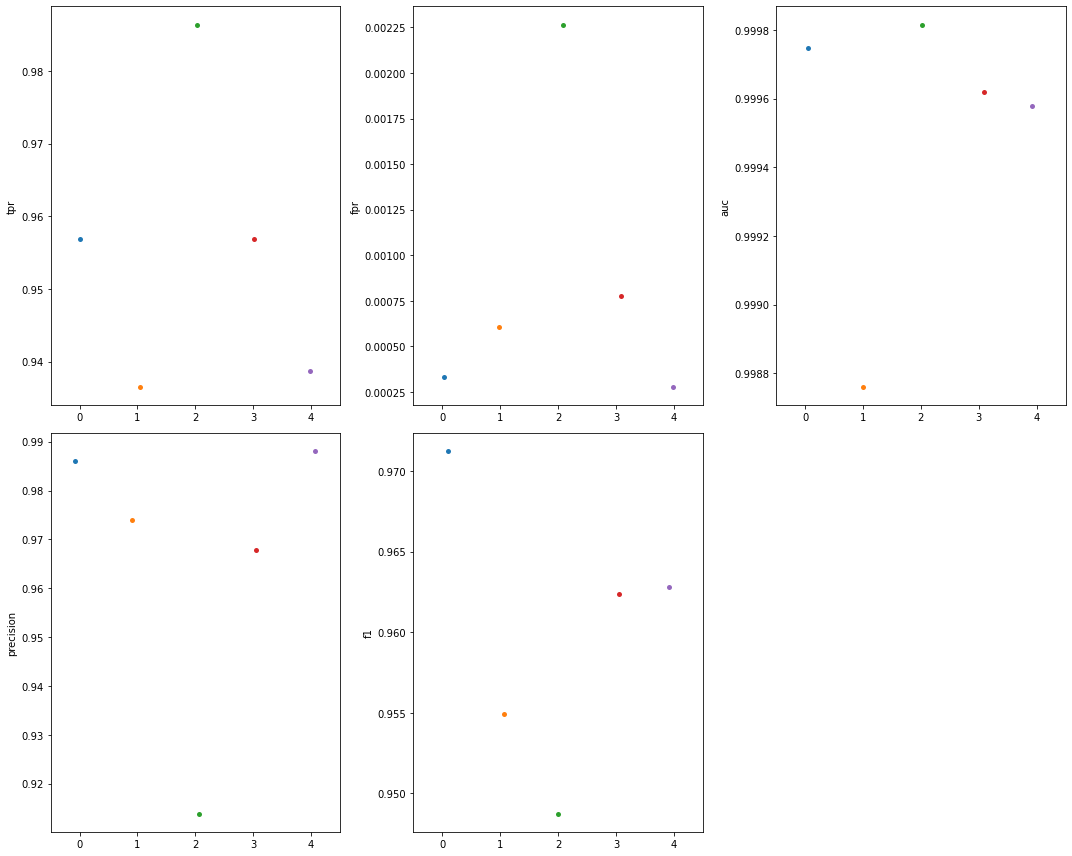

In [32]:
EVAL_METRICS = ['tpr', 'fpr', 'auc', 'precision', 'f1']

plt.figure(figsize=(15, 12))
for i, metric in enumerate(EVAL_METRICS, start=1):
    plt.subplot(230 + i)
    sns.stripplot(x=stats_df.index, y=stats_df[metric])
plt.tight_layout()

<font color='#005b96'>
As we already noticed via looking at the raw data,<br>
The second model has the best TPR.<br>
Even though it also has the largest FPR, the AUC score, which takes into account both the TPR and the FPR for various thresholds is the best for this model.

# Evaluation

<font color='#005b96'>
    <h2>Good examples</h2>

<font color='#005b96'>
    <h3>True Positive</h3>

In [33]:
model.eval();

In [34]:
idx_of_tp_samples_list = []

for i, row in val_dataset.df[val_dataset.df['label'] == 1].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p > 0.5:
        idx_of_tp_samples_list.append(i)
    if len(idx_of_tp_samples_list) >= 4:
        break
idx_of_tp_samples_list

[9, 79, 88, 109]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? True
Model certainty 0.9999961853027344
Does image 1 contains a mask? True
Model certainty 0.998664379119873
Does image 2 contains a mask? True
Model certainty 0.9999051094055176


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Does image 3 contains a mask? True
Model certainty 0.9999961853027344


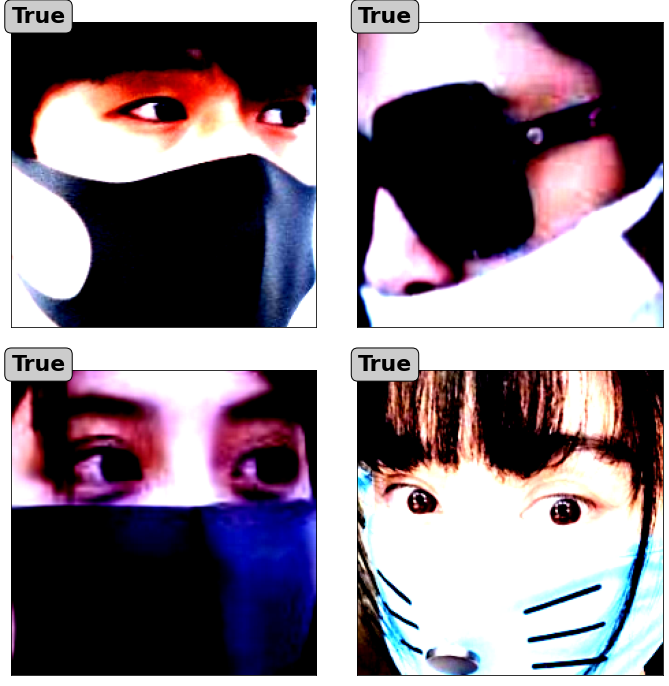

In [35]:
plot_image_from_dataset(val_dataset, idx_of_tp_samples_list, predict=True, model=model)

<font color='#005b96'>
The fourth image is very intresting, the mask isn't stadrad and it looks like cat mustache, it could of, but didn't fool our model.

<font color='#005b96'>
    <h3>True Negative</h3> 

In [61]:
idx_of_tn_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 0].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p <= 0.5:
        idx_of_tn_samples_list.append(i)
    if len(idx_of_tn_samples_list) >= 4:
        break
idx_of_tn_samples_list

[0, 1, 2, 3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? False
Model certainty 0.00016113244055304676
Does image 1 contains a mask? False
Model certainty 3.322800694149919e-05
Does image 2 contains a mask? False
Model certainty 0.003376559354364872
Does image 3 contains a mask? False
Model certainty 3.368639954715036e-05


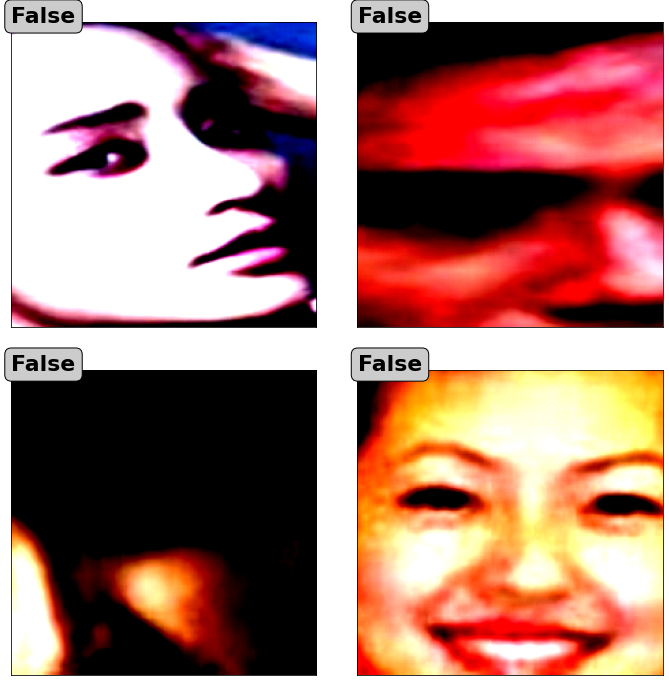

In [64]:
plot_image_from_dataset(train_dataset, idx_of_tn_samples_list, predict=True, model=model)

<font color='#005b96'>
I don't really see what's going on at the third image,<br>
it looks like an eye maybe, anyway it's not a mask for sure.

<h1>Bad example</h1>

<h1>False Positive</h1>

In [18]:
idx_of_fp_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 0].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p > 0.5:
        idx_of_fp_samples_list.append(i)
    if len(idx_of_fp_samples_list) >= 4:
        break
idx_of_fp_samples_list

[1017, 1291, 1618, 2982]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? True
Model certainty 0.5526717901229858
Does image 1 contains a mask? True
Model certainty 0.6444490551948547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 2 contains a mask? True
Model certainty 0.8335019946098328
Does image 3 contains a mask? True
Model certainty 0.5472682118415833


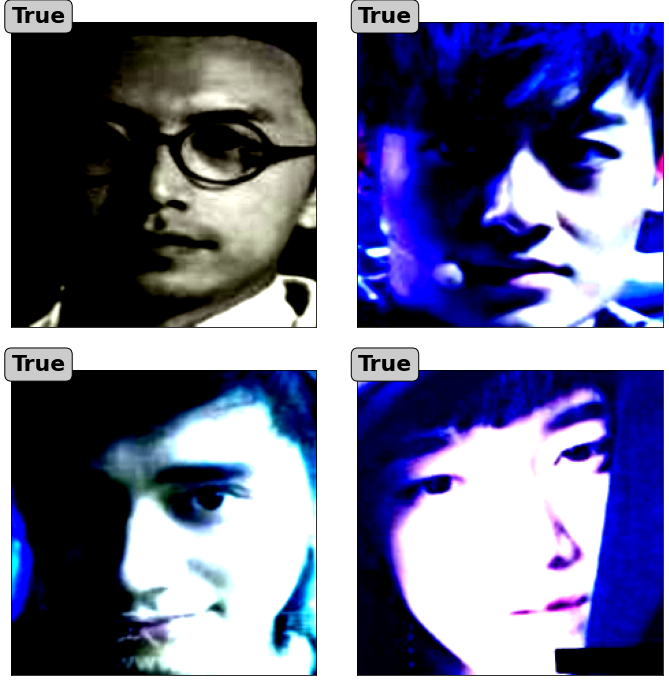

In [22]:
plot_image_from_dataset(val_dataset, idx_of_fp_samples_list, predict=True, model=model)

<h2>False Negative</h2>

In [23]:
idx_of_fn_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 1].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p <= 0.5:
        idx_of_fn_samples_list.append(i)
    if len(idx_of_fn_samples_list) >= 4:
        break
idx_of_fn_samples_list

[1035, 1142, 2525, 4153]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? False
Model certainty 0.35560184717178345
Does image 1 contains a mask? False
Model certainty 0.0017638617428019643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 2 contains a mask? False
Model certainty 0.37435123324394226
Does image 3 contains a mask? False
Model certainty 0.20696043968200684


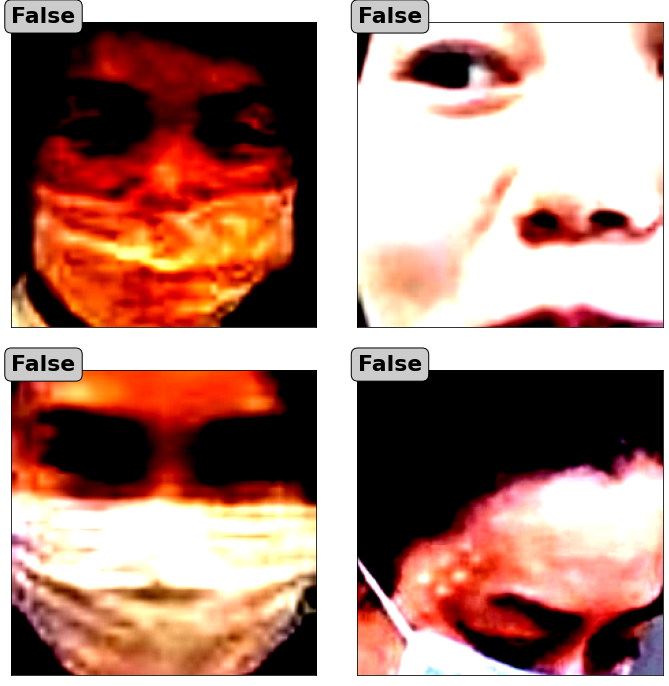

In [24]:
plot_image_from_dataset(val_dataset, idx_of_fn_samples_list, predict=True, model=model)

<font color='#005b96'>
By looking at the second image we can conclude that there was wrong labeling for sure,<br>
Actually the model was correct and the annotater was wrong :)<br>
So the second image sould be TN.<br>
It's questioning the entire labeling mechanism, whether it was done correctly.

<h1>Live Video</h1>

<font color='#005b96'>
Face-based identification can be roughly divided into two application scenarios: uncontrolled and controlled application environments.<br>
The former mainly refers to public video surveillance situations, where face shooting distance, view of sight, pose, occlusion and lighting are all uncertain.<br>
In these cases, the accuracy of face recognition is relatively low.<br>
Moreover, the accuracy will be further reduced when wearing a face mask.<br>
However, there are also a large number of controlled application scenarios, such as attendance checks in work places, security checks at train stations and facial scan payments, etc.<br>
In these situations, subjects are usually in a cooperative manner, typically, approaching and facing up the camera.<br>
In this section I'll emphasize how good the model could be on controlled application scenarios by applying it on live video!

<font color='#005b96'>
How would we perform it?<br>
A video is just a bunch of frames, AKA, images.<br>
So, we could just run a face detector that will detect faces, crop them, and feedforward those to our model.<br>
For the face detection task and the video processing i used opencv pretrained model and additional tools the package providing out of the box.<br>
Let's go!<br>
As soon as you run the next cell, your video camera will become active and the mask detector will start to classify you!

In [ ]:
import numpy as np
import cv2


cap = cv2.VideoCapture(0)

# Load the cascade
face_cascade = cv2.CascadeClassifier(str(haarcascade_model_dir / 'haarcascade_frontalface_default.xml'))


labelColor = {'No Mask': (10, 0, 255), 'Has Mask': (10, 255, 0)}

model.eval()
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    # Our operations on the frame come here
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    for face in face_cascade.detectMultiScale(image, 1.05, 5):
        xStart, yStart, width, height = face
        
        # clamp coordinates that are outside of the image
        xStart, yStart = max(xStart, 0), max(yStart, 0)

        cropped_face = image[yStart:yStart+height, xStart:xStart+width]
        
        img = val_transform()(Image.fromarray(cropped_face).convert('RGB'))

        output = model(img.unsqueeze(0).to(device))
        
        label = 'Has Mask' if output.item() > 0 else 'No Mask'
           
        cv2.rectangle(frame,
                      (xStart, yStart),
                      (xStart + width, yStart + height),
                      (126, 65, 64),
                      thickness=2)
        
        
        # center text according to the face frame
        textSize = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        textX = xStart + width // 2 - textSize[0] // 2

        # draw prediction label
        cv2.putText(frame,
                    label,
                    (textX, yStart-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, labelColor[label], 2)
    
    cv2.imshow('video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

<font color='#005b96'>
And here is a short video of me being classified by the model.

In [67]:
from IPython.display import Video

Video(videos_dir / "mask_detector.mp4")

# Interpretation

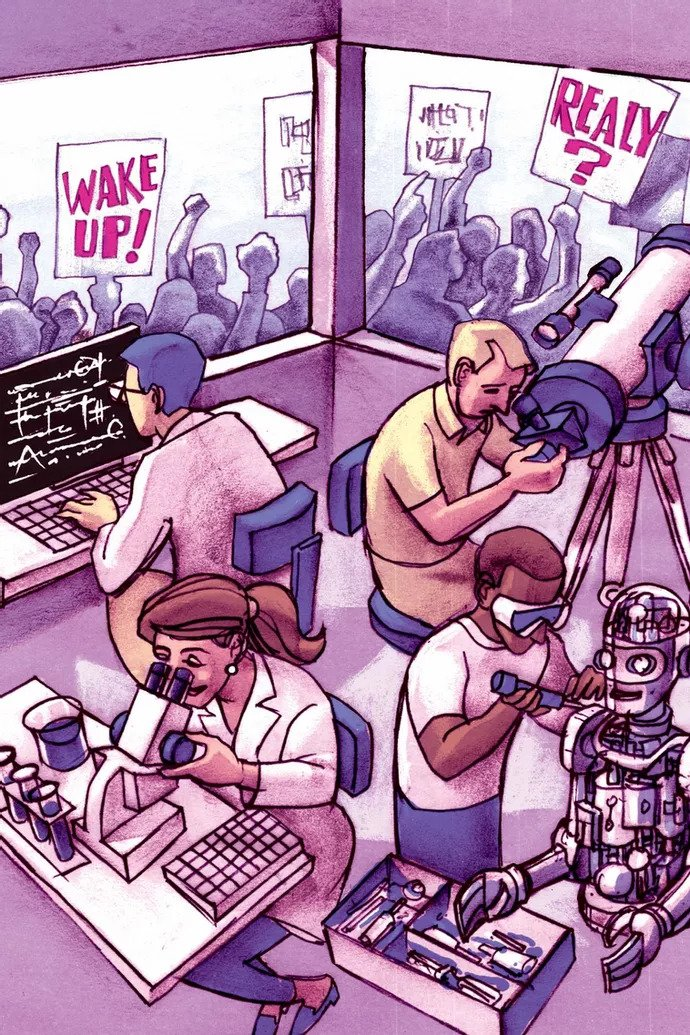

In [26]:
DisplayImage(images_dir / 'investigate.jpg', width=1200)

<font color='#005b96'>
Hot topic and one of the most challenging part to DS is model interpration.<br>
The theory behind building NN that will perform well for specific task is not well defined yet.<br>
It's more engineering than science for my opinion.<br>
You have some building blocks like CNN, RNN, several activation functions, some regularization methods and so on and so forth.<br>
But you can't really calculate were is the global minima for the loss function without some empirical results or at all.<br>
NN especially is kind of a black box.<br>
Think about a decision tree.<br>
It's far away easier to interpret DT than NN.<br>
DT has predefined features, you can calculate the Gini Index, and derive the information gain for each split and by that infer the features that contribute the most for deffrintiating between the class.<br>
You can also just count how many times you took a split for each feature, and it also could be great indicator for feature importance.<br>
In Computer Vision tasks like this one, we don't feed to the network extracted features.<br>
We let the NN extract those features for us from pixels,<br>
So the obvious question is:<br>
    <h2><font color='red'>How could we know what the network actually learns?</font></h2>
There is a lot of work going on in this field and it's just fascinating!<br>
To deal with this question i forked an implemention for the given papper:
    <h3> https://arxiv.org/pdf/1610.02391v1.pdf </h3>
I made several technichal adjustments so this implementation could help me to understand what my network actually learned.<br>
Link to my forked repository:
    <h3> https://github.com/MatanAvitan/grad-cam-pytorch </h3>
The general idea beahind this papper is the following:<br>
Let's take the last CNN layer of any NN that was trained for some CV task,<br>
The intuition is that in general the last layer captures the most high level features.<br>
Let's call the outputs from this layer activation maps (AM).<br>
Only after the last layer predict class, this class is then backpropogated through the NN.<br>
Than we calculte the gradients of this specific class with respect to each activation map, average pool them together and FF to Relu activation function.<br>
That way we localize and visualize the most important areas, which contribute the most for the current class' prediction.<br>

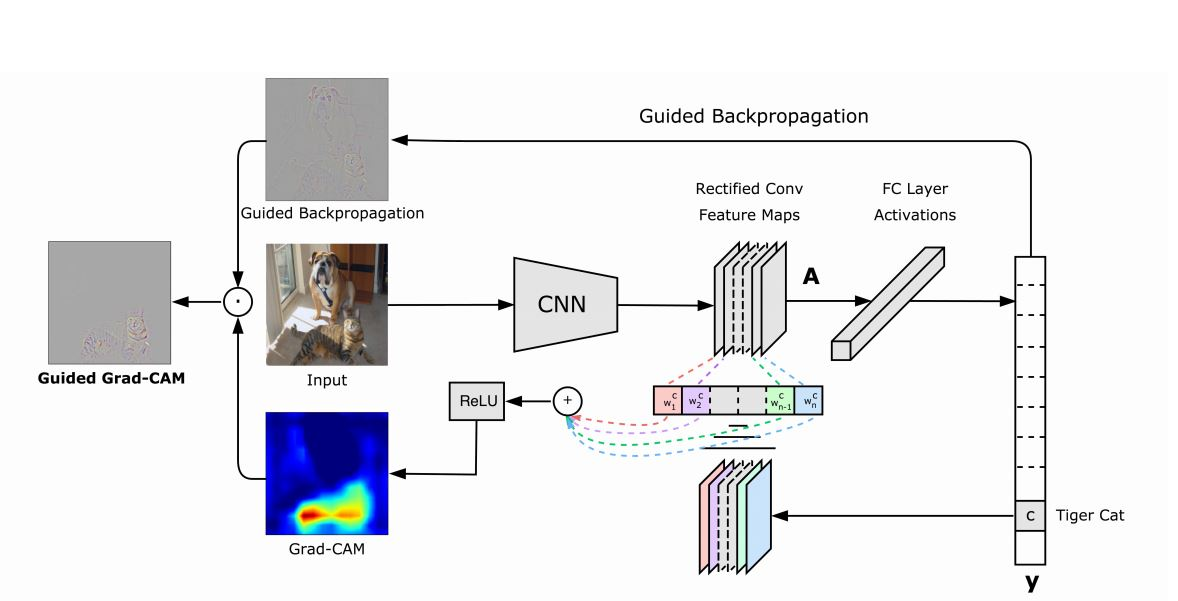

In [10]:
DisplayImage(images_dir / 'gradcam.jpg', width=1300)

In [14]:
def plot_gradcam_images(gradcam_imgs_path):
    fig, ax = plt.subplots(3, 3, figsize=(20,20))
    for i, p in enumerate(gradcam_imgs_path):
        img = Image.open(str(p))
        ax[i//3][i%3].imshow(np.asarray(img))
        ax[i//3][i%3].axis('off')
    plt.tight_layout()

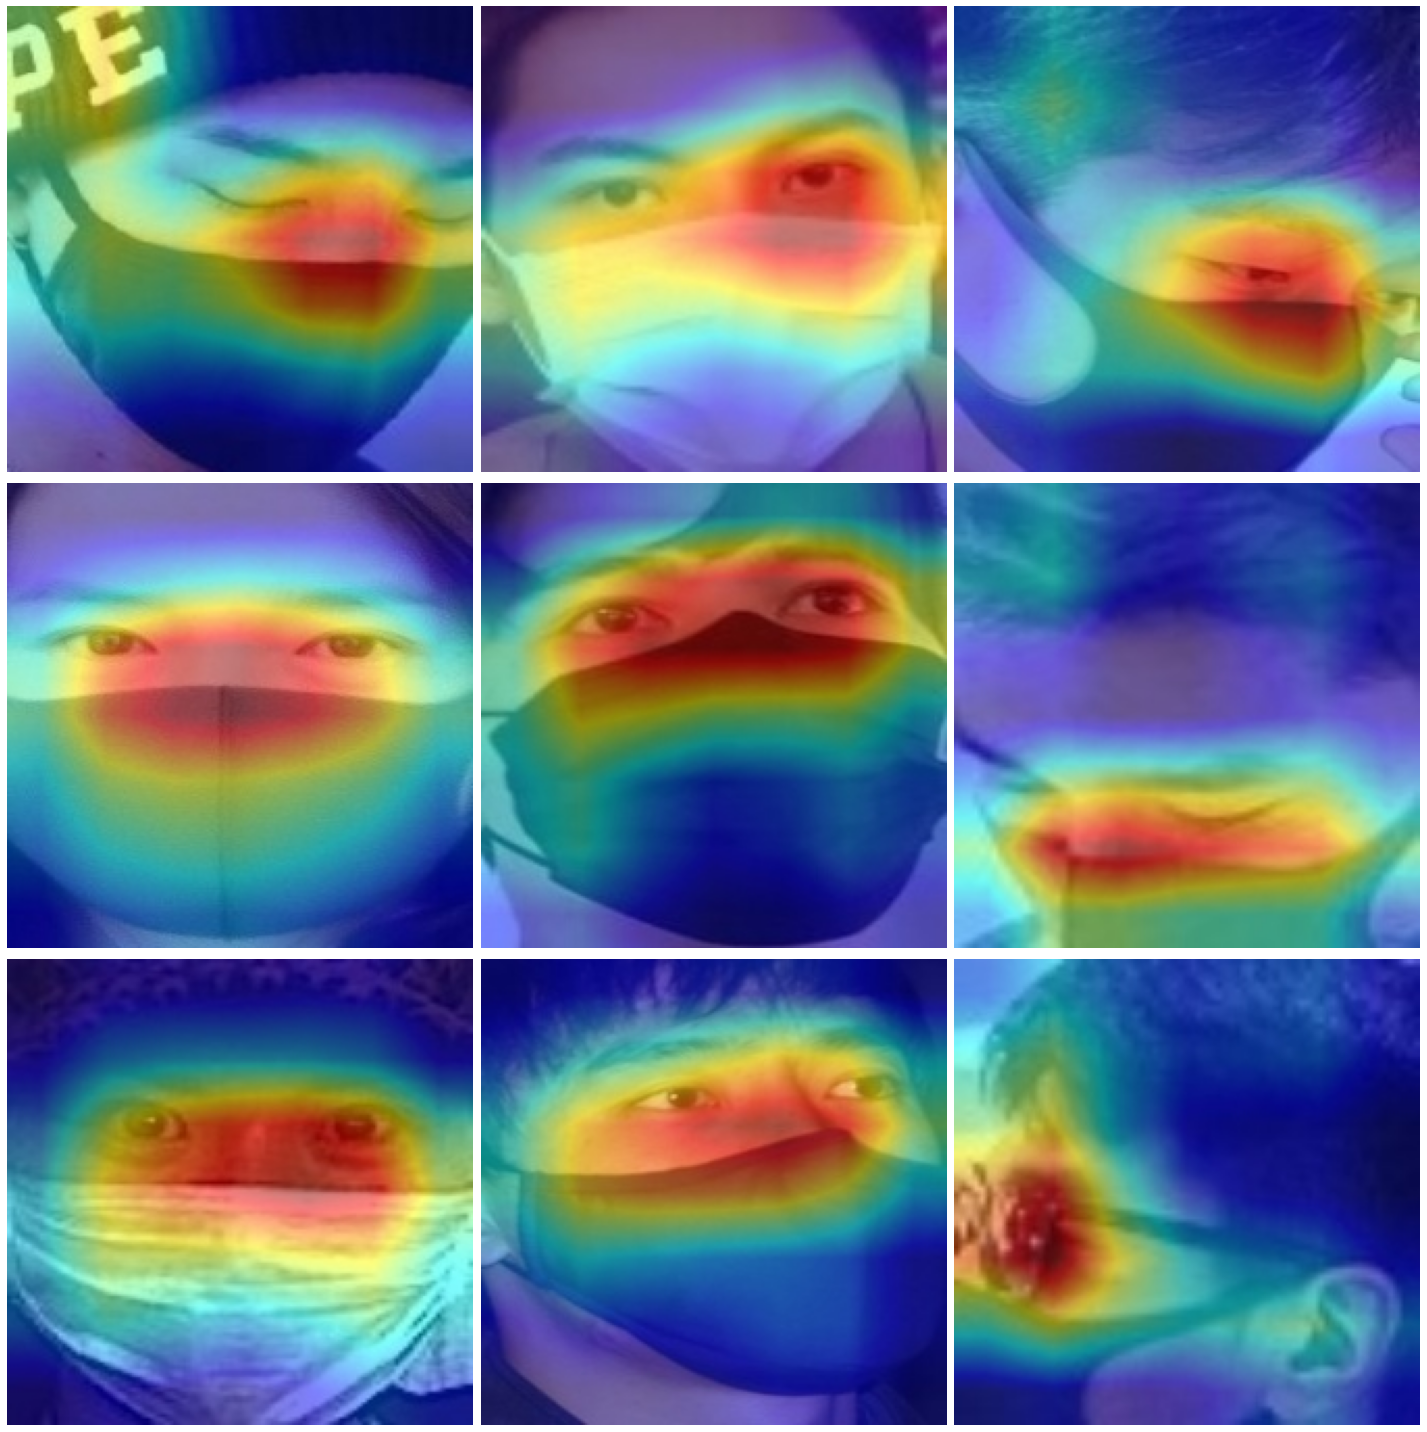

In [15]:
plot_gradcam_images(masked_gradcam_evaluation_dir.glob('*'))

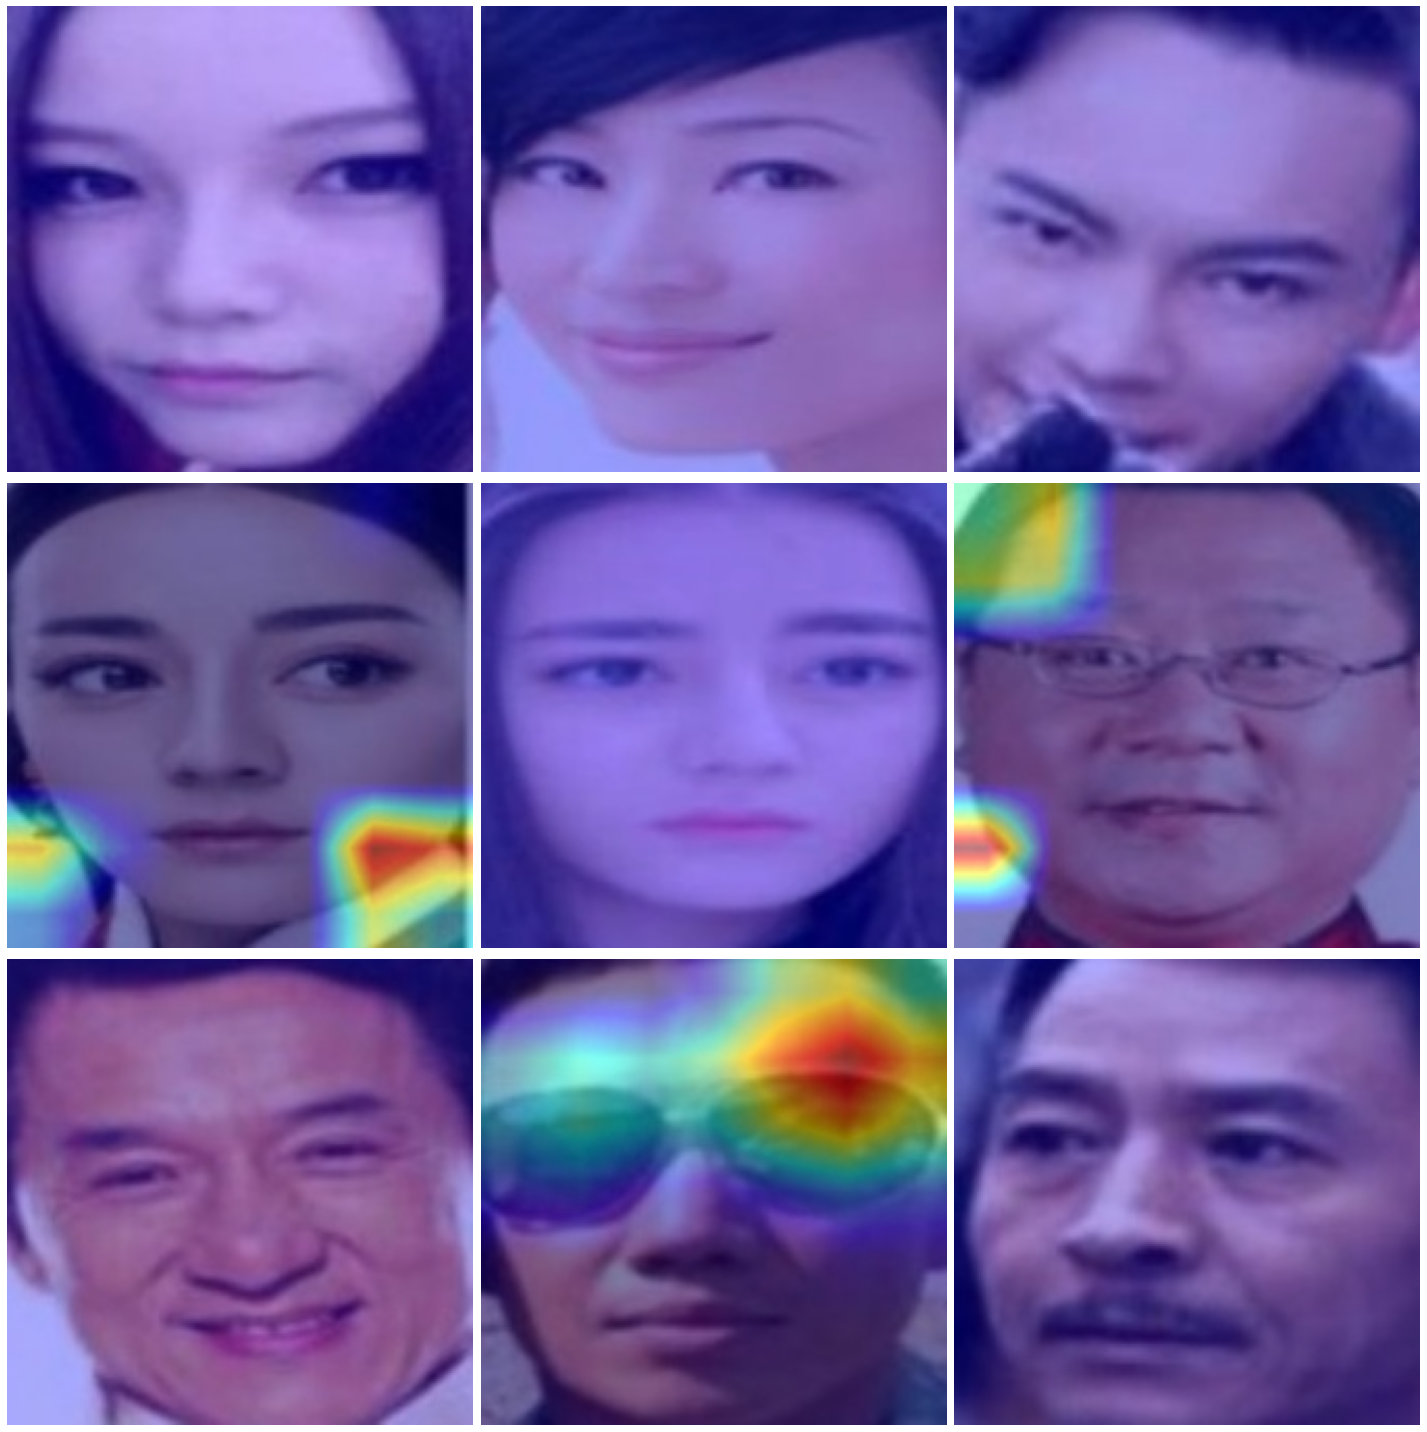

In [17]:
plot_gradcam_images(no_mask_gradcam_evaluation_dir.glob('*'))

<font color='#005b96'>
Incredible! <br>
It seems like the most important part of the face or "feature" is the connection between the top of the mask and the nose.<br>
It seemd like my network distinguish between "Has mask on the top of the nose + there is nose" and "Hasn't mask on the top of the nose + there is nose"

<h1>Next steps</h1>

If i had more compute resources i would try the next steps:<br>
* Examine other models like: EfficientNet, VGG, GoogLeNet, YOLO.
* Try ensemble of those networks or even concatenate feature maps of one network as input to the other.
* Search for more / better data and even annotate myself, the given images don't have the best quality and I even find incorrect annotations.
* Optimize the hyperparameters, for instanse trying SGD + Momentum instead of Adam optimizer, changing the batch size and so on and so forth.
* Even considering re-run the whole process again with different initial seed, maybe the network got stucked at local minima.
* Try to overfit, maybe after several epochs of increasing at the validation loss, there will be a significant decreasing(With an appropriate LR that could assist me getting out of those local minimas). 

Last but no least, because of the size of the project and his coolness,<br>
I actually upload it as LinkedIn post and got amazing comments and ~5K views!!<br>
<h4>https://www.linkedin.com/posts/matan-avitan-604b31156_machinelearning-coronaravirus-storytelling-activity-6714240181534294016-yxkR/</h4>